# Task 1: Effective Hamiltonian Model

## Imports

In [2]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from tqdm import tqdm

## Part 1.1

First, we want to simulate "inflating" a cat qubit in a two-mode system. Here are the given system parameters:

In [3]:
na, nb = 20, 5  # Hilbert space dimensions
T = 4.0  # Total simulation time
g2 = 1.0  # Two-photon coupling strength
eps_d = -4  # Drive amplitude
kappa_b = 10  # Decay rate

Using these parameters, we can define the initial (vacuum) state and our Hamiltonian:

In [4]:
psi0 = dq.fock((na, nb), (0, 0))  # Initial state

# Operators
a, b = dq.destroy(na, nb)
H_2ph = g2 * a.dag() @ a.dag() @ b + jnp.conj(g2) * a @ a @ b.dag()
H_d = jnp.conj(eps_d) * b + eps_d * b.dag()
H = H_2ph + H_d

For validation, we want to see how the expected number of photons evolves as the qubit inflates, so let's also define our expectation (photon number) operators:

In [5]:
exp_ops = [dq.dag(a) @ a, dq.dag(b) @ b]

In this effective model, there is only loss in mode b (the buffer mode):

In [6]:
loss_op = jnp.sqrt(kappa_b) * b

Finally, we have all the pieces to solve the Lindblad master equation using `dq.mesolve`:

In [7]:
t_save = jnp.linspace(0, T, 100)
res = dq.mesolve(H, [loss_op], psi0, t_save, exp_ops=exp_ops)

We want to plot the Wigner function of mode a, but `res` combines both modes, so we need a partial trace to isolate mode a. Using this partial trace, we can plot the time-evolution of the Wigner function as a gif:

100%|██████████| 50/50 [02:16<00:00,  2.73s/it]


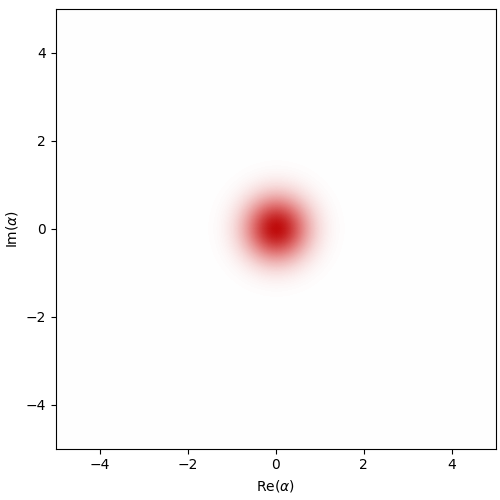

In [8]:
rho_a = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho_a)

Looks great! Let's also plot how the expected photon number evolves:

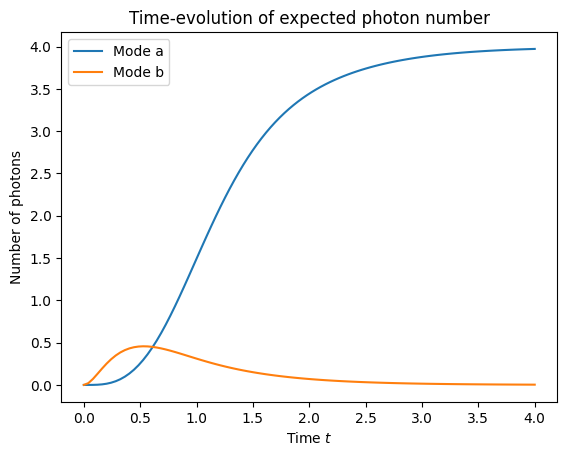

In [9]:
plt.plot(t_save, res.expects[0].real, label="Mode a")
plt.plot(t_save, res.expects[1].real, label="Mode b")
plt.xlabel(r"Time $t$")
plt.ylabel(r"Number of photons")
plt.title("Time-evolution of expected photon number")
plt.legend()
plt.show()

From the above plot, we observe the expected transient dynamics:
* The number of photons in the memory mode increases and converges to 4.
* The number of photons in the lossy buffer mode increases temporarily and decays to 0.

As a final validation, let's plot the parity of mode a and check that it's constant as expected:

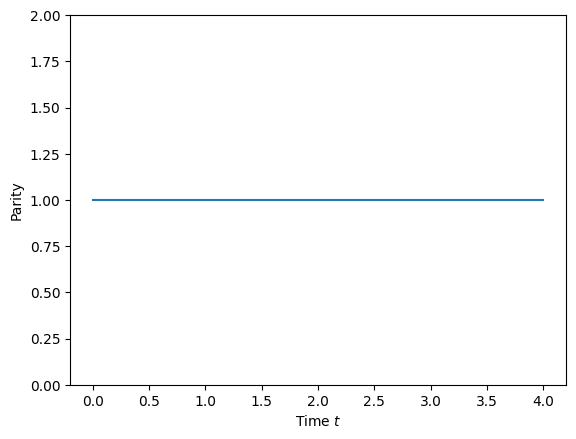

In [10]:
plt.plot(t_save, dq.expect(dq.parity(na), rho_a).real)
plt.xlabel(r"Time $t$")
plt.ylabel(r"Parity")
plt.ylim(0, 2)
plt.show()

## Part 1.2

Let's simplify this model even further! For a sufficiently lossy buffer mode, it is "adiabatically eliminated". TL;DR: We can ignore it and focus on only the memory mode.

We can define a new Hamiltonian and solve the Lindblad equation:

In [11]:
g2 = 1.0
eps_d = -4
kappa_b = 10
t_save = jnp.linspace(0, 0.4 * kappa_b, 100)

# New parameters!
kappa_2 = 4 * (g2**2) / kappa_b  # Two-photon loss rate
alpha_squared = -eps_d / jnp.conj(g2)  # Amplitude of the coherent state

a = dq.destroy(na)
psi0 = dq.fock(na, 0)
H = dq.zeros(na)
loss_op = jnp.sqrt(kappa_2) * (a @ a - alpha_squared * dq.eye(na))
exp_ops = [dq.dag(a) @ a]

res = dq.mesolve(H, [loss_op], psi0, t_save, exp_ops=exp_ops)

|██████████| 100.0% ◆ elapsed 1.10s ◆ remaining 0.00ms     


$\kappa_b$ is larger than $g_2$ and $\epsilon_d$ here, so our approximation should work. Let's plot the Wigner function and check that it matches that of 1.1:

100%|██████████| 50/50 [02:09<00:00,  2.60s/it]


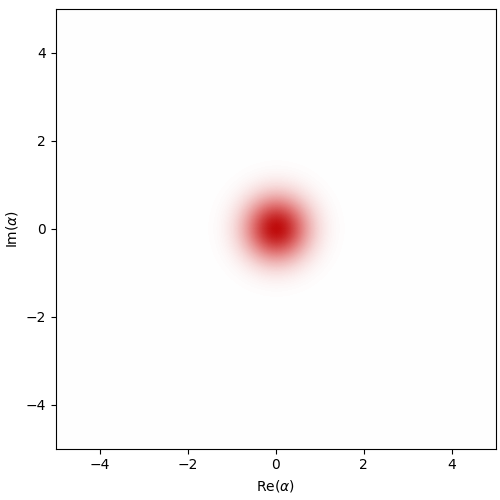

In [12]:
dq.plot.wigner_gif(res.states)

It matches! Let's also check the photon number plot:

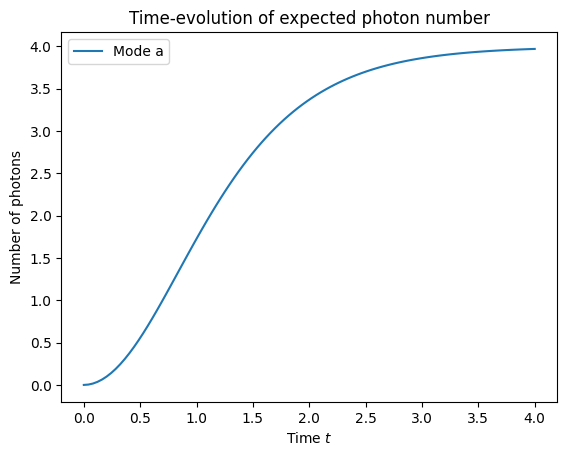

In [13]:
plt.plot(t_save, res.expects[0].real, label="Mode a")
plt.xlabel(r"Time $t$")
plt.ylabel(r"Number of photons")
plt.title("Time-evolution of expected photon number")
plt.legend()
plt.show()

Another (more rigorous) measure of similarity is **fidelity**, which Dynamiqs can calculate. Let's try lowering $\kappa_b$ and see how the fidelity changes.

(Note that $\kappa_2$ determines the rate of convergence, so we need to normalize the simulation time to be inversely proportional to $\kappa_2$. This is equivalent to making the simulation time directly proportional to $\kappa_b$.)

|██████████| 100.0% ◆ elapsed 13.30s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 1.40s ◆ remaining 0.00ms     
|██████████| 100.0% ◆ elapsed 5.50s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 1.20s ◆ remaining 0.00ms     
|██████████| 100.0% ◆ elapsed 2.20s ◆ remaining 0.00ms   
|██████████| 100.0% ◆ elapsed 891.72ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 999.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 704.69ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 1.00s ◆ remaining 0.00ms   
|██████████| 100.0% ◆ elapsed 1.30s ◆ remaining 0.00ms     


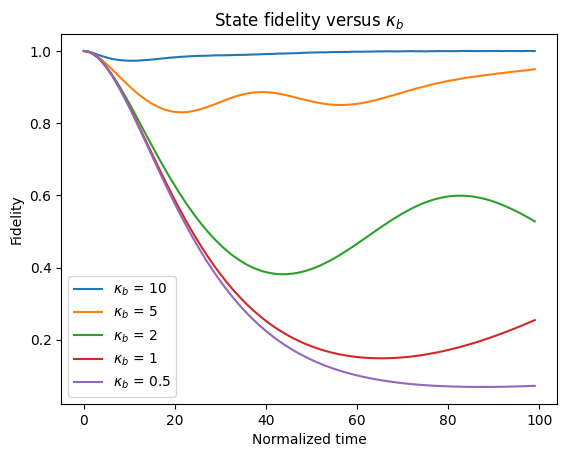

In [14]:
for kappa_b in [10, 5, 2, 1, 0.5]:
    # First get the ground-truth two-mode states
    na, nb = 20, 5
    T = 4.0
    g2 = 1.0
    eps_d = -4
    psi0 = dq.fock((na, nb), (0, 0))
    a, b = dq.destroy(na, nb)
    H_2ph = g2 * a.dag() @ a.dag() @ b + jnp.conj(g2) * a @ a @ b.dag()
    H_d = jnp.conj(eps_d) * b + eps_d * b.dag()
    H = H_2ph + H_d
    loss_op = jnp.sqrt(kappa_b) * b
    t_save = jnp.linspace(0, 0.4 * kappa_b, 100)
    twomode_res = dq.mesolve(H, [loss_op], psi0, t_save)
    rho_a = dq.ptrace(twomode_res.states, 0)
    
    # Compare with one-mode approximation
    kappa_2 = 4 * (g2**2) / kappa_b
    alpha_squared = -eps_d / jnp.conj(g2)
    a = dq.destroy(na)
    psi0 = dq.fock(na, 0)
    H = dq.zeros(na)
    loss_op = jnp.sqrt(kappa_2) * (a @ a - alpha_squared * dq.eye(na))
    onemode_res = dq.mesolve(H, [loss_op], psi0, t_save)

    # Plot fidelity
    fidelity = dq.fidelity(rho_a, onemode_res.states)
    plt.plot(fidelity, label=f"$\kappa_b$ = {kappa_b}")

plt.xlabel("Normalized time")
plt.ylabel("Fidelity")
plt.title(r"State fidelity versus $\kappa_b$")
plt.legend()
plt.show()

As we can see, fidelity dramatically decreases when the assumption of $\kappa_b \gg g_2, \epsilon_d$ no longer holds. But when $\kappa_b = 10$, the approximation is very accurate, with the fidelity never dropping below 95% during the simulation!

## Part 1.4

To optimize $\epsilon_d(t)$, we can do the following:
1. Discretize time and treat $\epsilon_d(t)$ as a piecewise linear function with $k$ parts.
2. Treat the values that $\epsilon_d(t)$ takes as a vector in $\mathbb{R}^k$.
3. Use gradient descent to iteratively update $\epsilon_d(t)$.

(1) and (2) are easy to implement using the `dq.pwc(...)` function. (3) is a bit more complicated:
* We need gradients to perform gradient descent. Luckily, Dynamiqs supports automatic differentiation using Jax!
* We need an appropriate loss function to quantify how good (or bad) a candidate $\epsilon_d(t)$ is.
    * We want the fidelity to converge to 1 as quickly as possible, so we can use the time-averaged fidelity as a measure of goodness.
    * However, a simpler approach is to regress on the **expected photon number** and make it converge to 4 as quickly as possible.

Let $n(\epsilon_d(t))$ be the expected number of photons at a given time $t$. A natural loss function is based on the mean-squared error (MSE):
$$\mathcal{L}_{\text{MSE}}(\epsilon_d(t)) = \frac{1}{T} \int_0^T (n(\epsilon_d(t)) - 4)^2 \;dt$$

However, we care more about minimizing loss at later times, so we can weight those times more:
$$\mathcal{L}_{\text{Weighted MSE}}(\epsilon_d(t)) = \frac{1}{T} \int_0^T (n(\epsilon_d(t)) - 4)^2 \cdot \color{red}\sqrt{1 + \alpha \cdot \frac{t}{T}} \color{black}\;dt$$
where $\alpha$ is a hyperparameter controlling the "shape" of the relative weighting. We found that $\alpha = 10$ works well.

Finally, we can discretize the integral and turn it into a summation, which makes this loss function computationally tractable.

In [15]:
def get_badness(eps_d_vec):
    k = len(eps_d_vec)
    num_timesteps = 200
    alpha_squared = 4
    kappa_b = 10
    na, nb = 20, 5
    T = 3.0
    t_save = jnp.linspace(0, T, num_timesteps)

    a, b = dq.destroy(na, nb)

    psi = dq.fock((na, nb), (0, 0))
    H_2ph = dq.pwc(jnp.linspace(0, T, k + 1), jnp.array(eps_d_vec) / alpha_squared,
                   -(a.dag() @ a.dag() @ b + a @ a @ b.dag()))
    H_d = dq.pwc(jnp.linspace(0, T, k + 1), eps_d_vec, b + b.dag())
    H = H_2ph + H_d
    loss_op = jnp.sqrt(kappa_b) * b
    res = dq.mesolve(H, [loss_op], psi, t_save, exp_ops=[dq.dag(a) @ a],
                     options=dq.Options(progress_meter=None))

    error = alpha_squared - res.expects[0].real
    badness = jnp.mean(error**2 * (1 + 10 * jnp.arange(num_timesteps) / num_timesteps)**0.5)

    return badness

In [ ]:
grad_badness = jax.grad(get_badness)
k = 10
eps_d_vec = jnp.ones(k) * -4
lr = 5
epochs = 20

print('Initial badness:', get_badness(eps_d_vec))
for i in tqdm(range(epochs)):
    eps_d_vec -= lr * grad_badness(eps_d_vec)
print('Final badness:', get_badness(eps_d_vec))

Initial badness: 8.298548


 35%|███▌      | 7/20 [11:21<16:26, 75.85s/it]   

As we can see, the loss decreases dramatically after just a few iterations of training. Some observations:
* Changing $T$ (the simulation time) will not affect the results of the simulation much. Making it larger will just make training slower. Making it smaller will likewise speed up training, but the function will not converge if $T$ is too small.

Let's visualize the results:

In [ ]:
plt.step(jnp.linspace(0, 3.0, k + 1), list(eps_d_vec) + [eps_d_vec[-1]])

In [ ]:
def visualize(eps_d_vec, label):
    k = len(eps_d_vec)
    alpha_squared = 4
    kappa_b = 10
    na, nb = 20, 5
    T = 3.0
    t_save = jnp.linspace(0, T, 200)

    a, b = dq.destroy(na, nb)

    psi = dq.fock((na, nb), (0, 0))
    H_2ph = dq.pwc(jnp.linspace(0, T, k + 1), jnp.array(eps_d_vec) / alpha_squared,
                   -(a.dag() @ a.dag() @ b + a @ a @ b.dag()))
    H_d = dq.pwc(jnp.linspace(0, T, k + 1), eps_d_vec, b + b.dag())
    H = H_2ph + H_d
    loss_op = jnp.sqrt(kappa_b) * b
    res = dq.mesolve(H, [loss_op], psi, t_save, exp_ops=[dq.dag(a) @ a],
                     options=dq.Options(progress_meter=None))

    plt.plot(res.expects[0], label=label)
    plt.xlabel(r"Time $t$", fontsize=12)
    plt.ylabel(r"Number of photons", fontsize=12)

In [ ]:
visualize(jnp.ones(k) * -4, r'Constant $\epsilon_d$')
visualize(eps_d_vec, r'Optimized $\epsilon_d(t)$')
plt.legend()
plt.title('Time-evolution of expected photon count')
plt.show()

The optimized $\epsilon_d(t)$ makes the state inflate more than twice as quickly! To verify our result, let's make sure that the final state is actually what we expect:

In [ ]:
rho_a = dq.ptrace(final_state, 0)
dq.plot.wigner(rho_a)

In [ ]:
def plot_fidelity(eps_d_vec, label, target_state):
    k = len(eps_d_vec)
    alpha_squared = 4
    kappa_b = 10
    na, nb = 20, 5
    T = 3.0
    t_save = jnp.linspace(0, T, 200)

    a, b = dq.destroy(na, nb)

    psi = dq.fock((na, nb), (0, 0))
    H_2ph = dq.pwc(jnp.linspace(0, T, k + 1), jnp.array(eps_d_vec) / alpha_squared,
                   -(a.dag() @ a.dag() @ b + a @ a @ b.dag()))
    H_d = dq.pwc(jnp.linspace(0, T, k + 1), eps_d_vec, b + b.dag())
    H = H_2ph + H_d
    loss_op = jnp.sqrt(kappa_b) * b
    res = dq.mesolve(H, [loss_op], psi, t_save, exp_ops=[dq.dag(a) @ a],
                     options=dq.Options(progress_meter=None))

    fidelity = dq.fidelity(target_state, res.states)

    plt.plot(fidelity, label=label)
    plt.xlabel(r"Time $t$", fontsize=12)
    plt.ylabel(r"Fidelity", fontsize=12)

In [ ]:
plot_fidelity(jnp.ones(k) * -4, 'Before', target_state)
plot_fidelity(eps_d_vec, 'After', target_state)
plt.axhline(0.95, color='gray', linestyle='--', label='95% fidelity threshold')
plt.legend()
plt.show()

The fidelity is very good, so our approach works!